In [1]:
import cvxpy as cp
from mip_cvxpy import PYTHON_MIP

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 15 09:40:15 AM: Your problem has 3300 variables, 765 constraints, and 0 parameters.
(CVXPY) Feb 15 09:40:15 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 15 09:40:15 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 15 09:40:15 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 15 09:40:15 AM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Feb 15 09:40:15 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

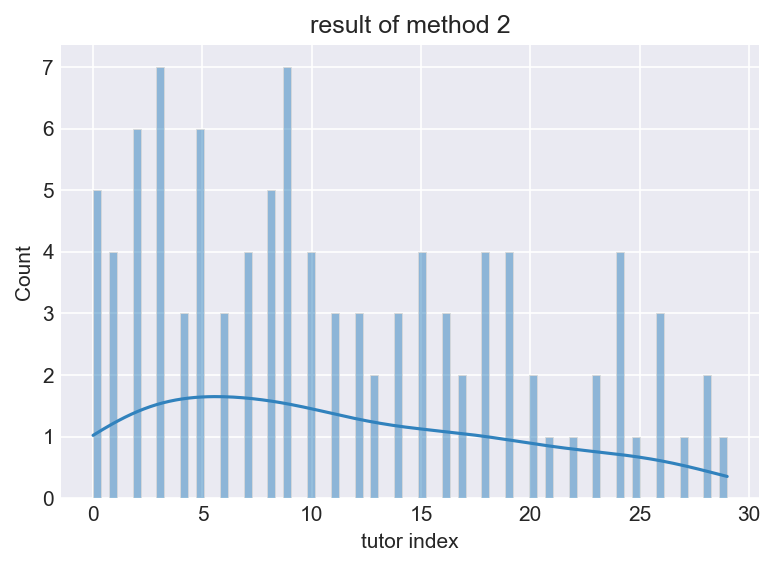

In [2]:
student = pd.read_csv("studentdata.csv")
tutorslist = pd.read_csv("tutordata.csv")
#########################################################
# 变量声明
x = cp.Variable(shape=(student.shape[0],tutorslist.shape[0]),boolean=True)
y = cp.Variable(shape=(student.shape[0],1),boolean=True)

s1 = cp.Variable(shape=(student.shape[0],1),boolean=True)
s2 = cp.Variable(shape=(student.shape[0],1),boolean=True)

#########################################################
# 加入约束7-9
constraints = [#s1>=np.zeros((student.shape[0],1)),
               #s2>=np.zeros((student.shape[0],1)),
               y >= np.ones((student.shape[0],1))-s1,
               y >= np.ones((student.shape[0],1))-s2,
               y <= 2*np.ones((student.shape[0],1))-s1-s2
              ]
#########################################################
# 加入约束1
constraints.append(x@np.ones((tutorslist.shape[0],1)) <= np.ones((student.shape[0],1)))
constraints.append(x@np.ones((tutorslist.shape[0],1)) >= np.ones((student.shape[0],1)))
#########################################################
# 加入约束2
for i in range(0,tutorslist.shape[0]):
    constraints.append((np.ones((1,student.shape[0]))@x)[0][i] <= tutorslist["upper"][i])
    constraints.append((np.ones((1,student.shape[0]))@x)[0][i] >= tutorslist["lower"][i])

# 加入约束4

for i in range(0,student.shape[0]):
    Tji = np.zeros((tutorslist.shape[0],1))
    for j in range(1,5):
        Tji[student.iloc[i,j]]=1
    constraints.append(x[i]@Tji+s2[i]==1)
    
#########################################################  
# 加入约束5
# w students' field
for w in range(1,5):
    # row number of students list
    for i in range(0,student.shape[0]):
        indexlist = np.zeros((tutorslist.shape[0],1))
        # find tutor
        for j in range(0,tutorslist.shape[0]):
            # categories for a tutor
            if(student.iloc[i,w] in tutorslist.iloc[j,1:5].values.tolist()):
                indexlist[j] = 1
        constraints.append(s1[i]<= 1 - x[i]@indexlist)
    
#########################################################
# 加入约束6 

for i in range(0,student.shape[0]):
    sum=0
    for w in range(1,5):
        indexlist = np.zeros((tutorslist.shape[0],1))
        # find tutor
        for j in range(0,tutorslist.shape[0]):
            # categories for a tutor
            if(student.iloc[i,w] in tutorslist.iloc[j,1:5].values.tolist()):
                indexlist[j] = 1
        sum +=indexlist
    constraints.append(s1[i]>= 1 - x[i]@sum)
#########################################################

# add constrain 11
    constraints.append(np.ones(((1,student.shape[0])))@y==100)

##############################################################
#redfine object function

sum = 0
for  i in range(0,student.shape[0]):
    t = np.zeros((tutorslist.shape[0],1))
    # field sequence
    for j in range(1,5):
        t[student.iloc[i,j]] = 4 + 1 - j
    for j in range(5,9):
        for k in range(0,tutorslist.shape[0]):
            # categories for a tutor
            # if(student.iloc[i,j] in tutorslist.iloc[k,1:5].values.tolist()):
                t[k] += (4 + 5 -j)
    sum += x[i]@t           


obj = cp.Minimize(sum)
#obj = cp.Minimize((-np.ones(((1,student.shape[0]))))@y)
prob = cp.Problem(obj,constraints=constraints)
prob.solve(solver='GLPK_MI',verbose=True)

print("\nThe optimal value is", prob.value)
print("A solution x is")
output = []
for item in x.value:
    for i in range(0,tutorslist.shape[0]):
        if item[i]==1:
            output.append(i)
print(x.shape)
print(output)
plt.figure(dpi=150)
plt.style.use('seaborn-darkgrid') #'seaborn-bright'
palette = plt.get_cmap('tab20c')#'Pastel2') # 'Set1' 
figer = sns.histplot(output,kde = True,bins=80,shrink = 1, color = palette.colors[0], edgecolor = palette.colors[-1])#"none")#, element="step")# element = "poly") # cumulative = True
figer.set_title("result of method 2")
figer.set_xlabel("tutor index")
plt.savefig("m2.svg",dpi=2000)

In [3]:
top1 = np.zeros((20,6))
# 对于所有学生
for i in range(0,student.shape[0]):
    # 对于它可选的导师
    for j in range(0,tutorslist.shape[0]):
        # 选中某个导师
        if x.value[i][j]==1:
            # 学生的志愿排序
            flag = 0
            for w in range(1,5):
                if student.iloc[i,w] in tutorslist.iloc[j,1:4].values.tolist():
                    top1[student.iloc[i,w]-1][w] +=1
                    flag = 1
                    break
            if flag==0:
                top1[tutorslist.iloc[j,1]][5]+=1
for i in range(0,20):
    top1[i][0] = i+1

In [4]:
top = pd.DataFrame(top1,columns=["index","top1","top2","top3","top4","not in top list"])

<Figure size 6000x4000 with 0 Axes>

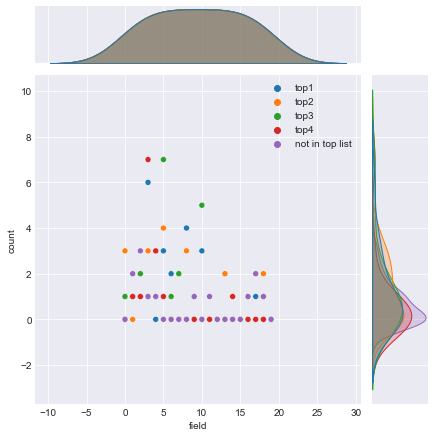

In [5]:
plt.figure(dpi=1000)
figer = sns.jointplot(top.iloc[0:,1:])
figer.set_axis_labels(xlabel="field",ylabel="count")
plt.savefig("fieldWithindexM2.svg",dpi=1000)

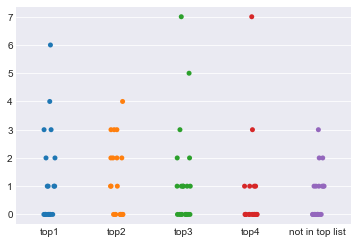

In [6]:
figer = sns.stripplot(top.iloc[0:,1:])
plt.savefig("timesOfcatergoryM2.svg",dpi =1000)

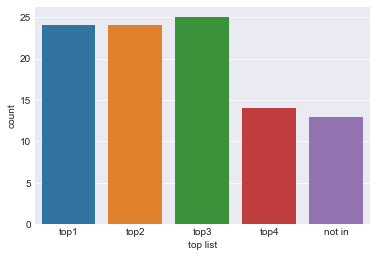

In [7]:
times =[["top1","top2","top3","top4","not in"],
        [0,0,0,0,0]
        ]
for i in range(1,6):
    times[1][i-1]=np.sum(top.iloc[0:,i])
figer = sns.barplot(y=times[1],x=times[0],errorbar=None)
figer.set_ylabel("count")
figer.set_xlabel("top list")
plt.savefig("m2result.svg",dpi = 1000)

In [9]:
times

[['top1', 'top2', 'top3', 'top4', 'not in'], [24.0, 24.0, 25.0, 14.0, 13.0]]

In [ ]:
student